In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from analysis.ngram import calculate_avg_ll
from analysis.plot_utils import plt, legend_opts, savefig

## Combine models sequentially

In [3]:
train_prob_matrix = np.load('../data/train_prob_matrix.npy')
dev1_prob_matrix = np.load('../data/dev1_prob_matrix.npy')
dev2_prob_matrix = np.load('../data/dev2_prob_matrix.npy')

In [4]:
train_avg_lls = []
dev1_avg_lls = []
dev2_avg_lls = []
labels = []
label = ''

ngram_combo = []
for n in range(6):
    ngram_combo.append(n)
    train_avg_lls.append(calculate_avg_ll(train_prob_matrix[:, ngram_combo]))
    dev1_avg_lls.append(calculate_avg_ll(dev1_prob_matrix[:, ngram_combo]))
    dev2_avg_lls.append(calculate_avg_ll(dev2_prob_matrix[:, ngram_combo]))
    
    label += f'{n}\n'
    labels.append(label)
labels[0] = '0\n(uniform)'

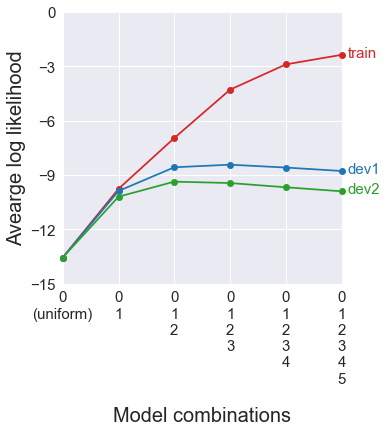

In [5]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(ngram_combo, train_avg_lls, '-o', color='tab:red', clip_on=False)
ax.plot(ngram_combo, dev1_avg_lls, '-o', color='tab:blue', clip_on=False)
ax.plot(ngram_combo, dev2_avg_lls, '-o', color='tab:green', clip_on=False)

ax.text(5.1, train_avg_lls[-1]+0.1, s='train', va='center', color='tab:red', fontsize=15)
ax.text(5.1, dev1_avg_lls[-1]+0.1, s='dev1', va='center', color='tab:blue', fontsize=15)
ax.text(5.1, dev2_avg_lls[-1]+0.1, s='dev2', va='center', color='tab:green', fontsize=15)

ax.set_xticklabels(labels)
ax.set_xlabel('Model combinations')
ax.set_ylabel('Avearge log likelihood')
ax.set_xlim(0, 5)
ax.set_ylim(-15, 0)
ax.set_yticks(range(-15, 1, 3))
plt.show()

## Expectation-maximation algorithm

### Interpolating 2 models

In [6]:
dev_prob_matrix = np.vstack([dev1_prob_matrix, dev2_prob_matrix])
dev_prob_matrix.shape

(803176, 6)

In [8]:
unigram_weights = np.linspace(0.0001, 1-0.0001, 100)
dev1_avg_lls = []
dev2_avg_lls = []
dev_avg_lls = []


for unigram_weight in unigram_weights:
    dev1_avg_lls.append(calculate_avg_ll(dev1_prob_matrix[:, [0, 1]], weights=[1-unigram_weight, unigram_weight]))
    dev2_avg_lls.append(calculate_avg_ll(dev2_prob_matrix[:, [0, 1]], weights=[1-unigram_weight, unigram_weight]))
    dev_avg_lls.append(calculate_avg_ll(dev_prob_matrix[:, [0, 1]], weights=[1-unigram_weight, unigram_weight]))

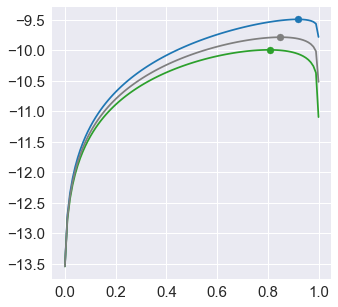

In [9]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(unigram_weights, dev1_avg_lls, color='tab:blue', clip_on=False)
ax.plot(unigram_weights, dev2_avg_lls, color='tab:green', clip_on=False)
ax.plot(unigram_weights, dev_avg_lls, color='tab:gray', clip_on=False)

ax.scatter(unigram_weights[np.argmax(dev1_avg_lls)], np.max(dev1_avg_lls), color='tab:blue', clip_on=False)
ax.scatter(unigram_weights[np.argmax(dev2_avg_lls)], np.max(dev2_avg_lls), color='tab:green', clip_on=False)
ax.scatter(unigram_weights[np.argmax(dev_avg_lls)], np.max(dev_avg_lls), color='tab:gray', clip_on=False)

### E-step

Average log likelihood vs lower bound of average likelihood for first word in combined `dev` set

In [69]:
def calculate_lower_bound_avg_ll(word_probs, true_weights, posterior_weights):
    lower_bound_avg_ll = np.sum(posterior_weights * np.log2(word_probs * true_weights / posterior_weights))
    return lower_bound_avg_ll

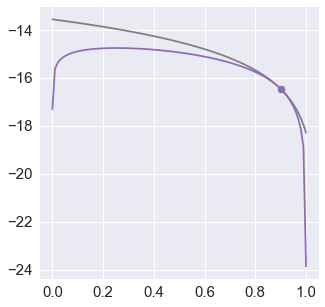

In [88]:
first_word_probs = dev_prob_matrix[[0], :2]
unigram_step_weight = 0.9
weighted_probs = first_word_probs * [1 - unigram_step_weight, unigram_step_weight]
posterior_weights = weighted_probs / np.sum(weighted_probs)

first_word_avg_lls = []
first_word_lower_bound_avg_lls = []

unigram_weights = np.linspace(0.0001, 1-0.0001, 100)
for unigram_weight in unigram_weights:
    first_word_avg_ll = calculate_avg_ll(first_word_probs, weights=[1-unigram_weight, unigram_weight])
    first_word_avg_lls.append(first_word_avg_ll)
    
    first_word_lower_bound_avg_ll = calculate_lower_bound_avg_ll(first_word_probs,
                                                                 true_weights=[1-unigram_weight, unigram_weight],
                                                                 posterior_weights=posterior_weights)
    first_word_lower_bound_avg_lls.append(first_word_lower_bound_avg_ll)
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(unigram_weights, first_word_avg_lls, color='tab:gray', clip_on=False)
ax.plot(unigram_weights, first_word_lower_bound_avg_lls, color='tab:purple', clip_on=False)
ax.scatter(unigram_step_weight, calculate_avg_ll(first_word_probs, weights=[1-unigram_step_weight, unigram_step_weight]), color='tab:gray', clip_on=False)
ax.scatter(unigram_step_weight, 
           calculate_lower_bound_avg_ll(first_word_probs,
                                       true_weights=[1-unigram_step_weight, unigram_step_weight],
                                       posterior_weights=posterior_weights),
           color='tab:purple', clip_on=False)

### EM algorithm

In [75]:
def get_em_weights(prob_matrix, n_iter=50):
    n_models = prob_matrix.shape[1]
    weights = np.ones(n_models) / n_models

    for i in range(n_iter):
        weighted_probs = prob_matrix * weights
        total_probs = weighted_probs.sum(axis=1, keepdims=True)

        # E-step
        posterior_weights = weighted_probs / total_probs

        # M-step
        weights = posterior_weights.mean(axis=0)
    return weights

In [86]:
dev_weights = get_em_weights(dev_prob_matrix[:, [0, 1]])

In [87]:
dev_weights

array([0.14949361, 0.85050639])